### Task5: Обучение без учителя

#### Импорт необходимых библиотек

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

#### Набор данных

Был выбран датасет для распознования чисел, написанных от руки на китайском. В сборе данных приняли участие 100 граждан Китая. Каждый участник написал 15 чисел (от 0 до 10, 100, 1000, 10 000, 100 000 000), каждое число по 10 раз, в итоге получилось 15 000 изображений рукописных чисел размером 64x64. Столбцы с 1 по 4096 представляют информацию о пикселях, последние 2 столбца - это арабские цифры (числа) и иероглиф на китайском.

In [35]:
df = pd.read_csv("chineseMNIST.csv")

df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4088,pixel_4089,pixel_4090,pixel_4091,pixel_4092,pixel_4093,pixel_4094,pixel_4095,label,character
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,九


In [36]:
df.shape

(15000, 4098)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Columns: 4098 entries, pixel_0 to character
dtypes: int64(4097), object(1)
memory usage: 469.0+ MB


#### Разведочный анализ (EDA)

In [38]:
is_miss = False
for value in df.isna().sum():
    if value > 0:
        is_miss = True
        break
if is_miss:
    print("В наборе есть пропущенные значение")
else:
    print("В наборе нет пропущенных значений")

В наборе нет пропущенных значений


Для удобства заменим числа 100, 1000, 10 000, 100 000 000 на 11, 12, 13, 14.

In [39]:
df["label"].replace(100, 11, inplace=True)
df["label"].replace(1000, 12, inplace=True)
df["label"].replace(10000, 13, inplace=True)
df["label"].replace(100000000, 14, inplace=True)

In [40]:
y = df["label"]
X = df.drop(columns=["label", "character"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

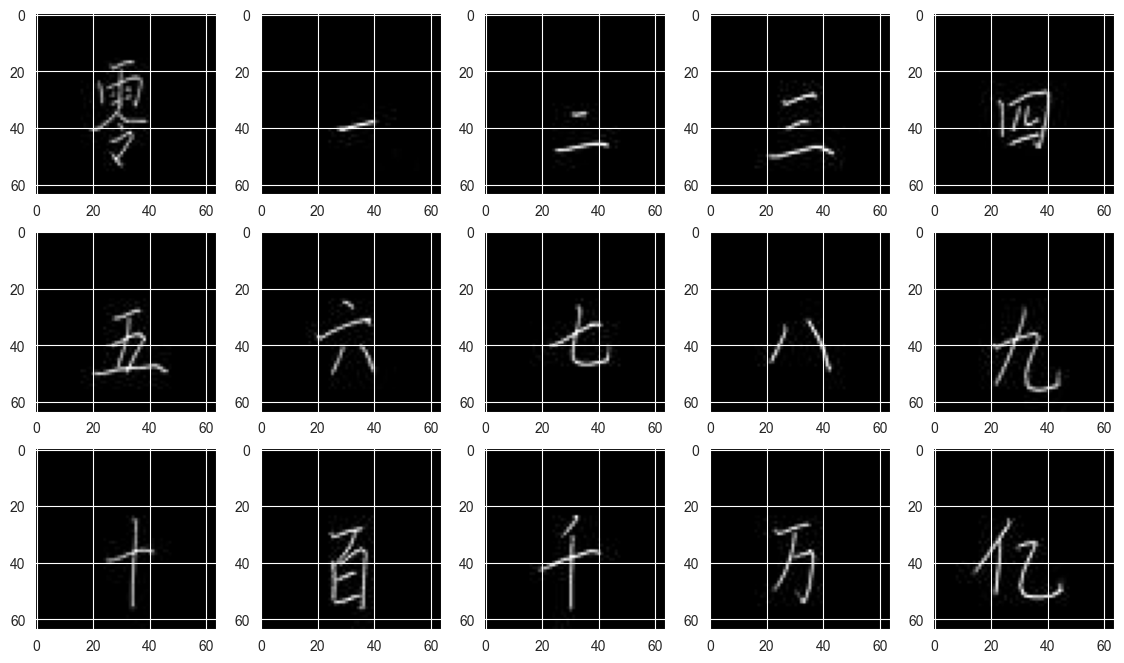

In [41]:
plt.figure(figsize=(14, 8))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    digits = df.loc[df["label"] == i]
    digits.drop(columns=["label", "character"], inplace=True)
    plt.imshow(digits.iloc[0].values.reshape([64, 64]), cmap='gray')

Визуализируем датасет, уменьшив его размерность до 2 при помощи алгоритмов PCA и t-SNE.

In [42]:
def draw_2d_projection(X: pd.DataFrame, algo_name: str):
    plt.figure(figsize=(13, 10))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 14), edgecolors="none",
                alpha=0.4)
    plt.colorbar()
    plt.title(f"2D projection from {algo_name}")
    plt.grid(None)

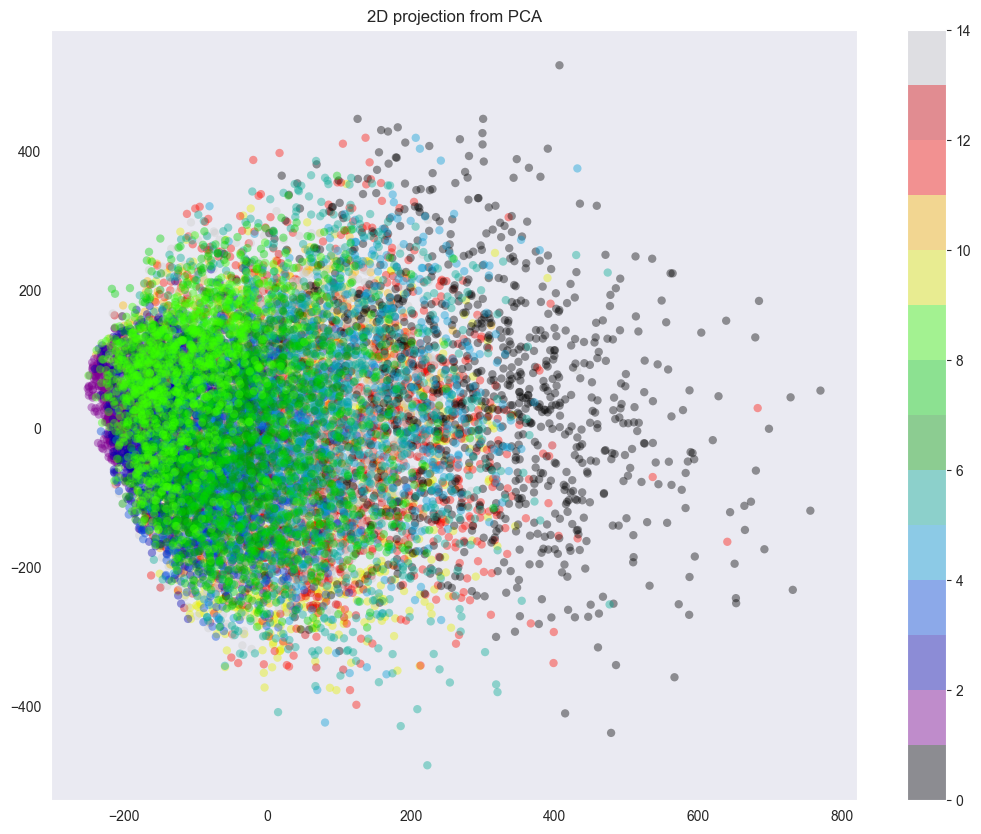

In [43]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

draw_2d_projection(X_pca, "PCA")

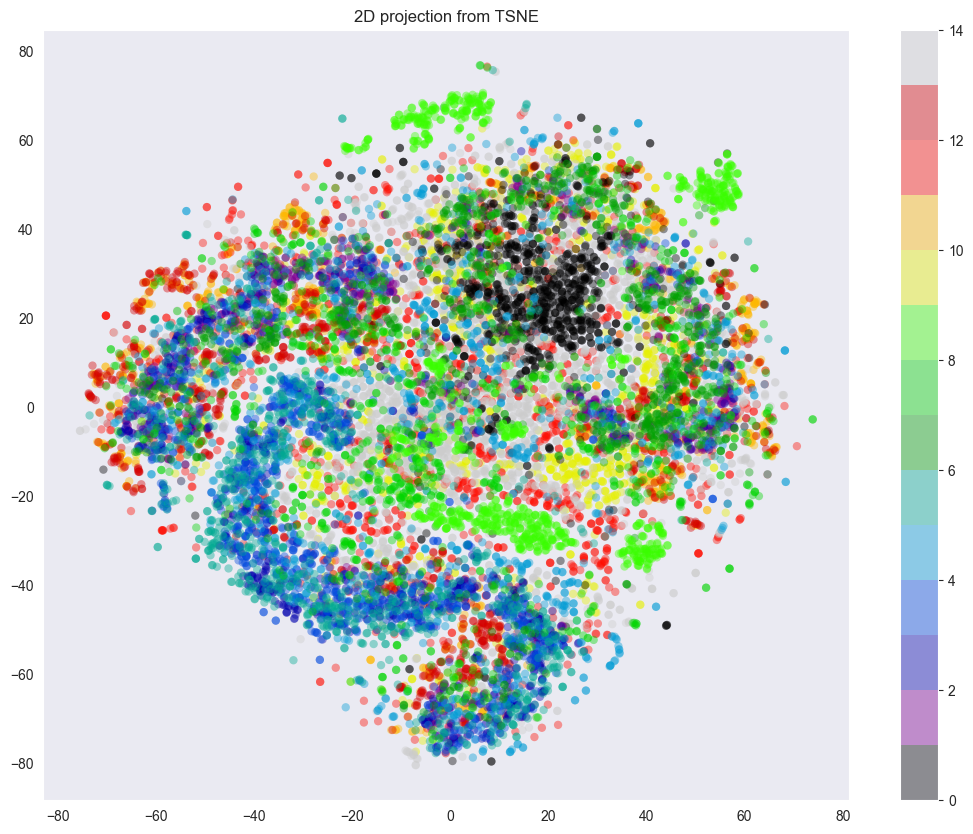

In [44]:
tsne = TSNE(random_state=0)
X_tsne = tsne.fit_transform(X.to_numpy())

draw_2d_projection(X_tsne, "TSNE")

В случае уменьшения размерности при помощи алгоритма PCA объекты разных групп сильно перемешены и никаких кластеров не прослеживается. С алгоритмом t-SNE ситуация не сильно лучше и тоже явных кластеров не наблюдается.

Рассмотрим насколько можно снизить количество главных компонент, чтобы уменьшить размерность датасета и при этом не потерять полезную информацию о данных.

In [45]:
pca = PCA().fit(X)

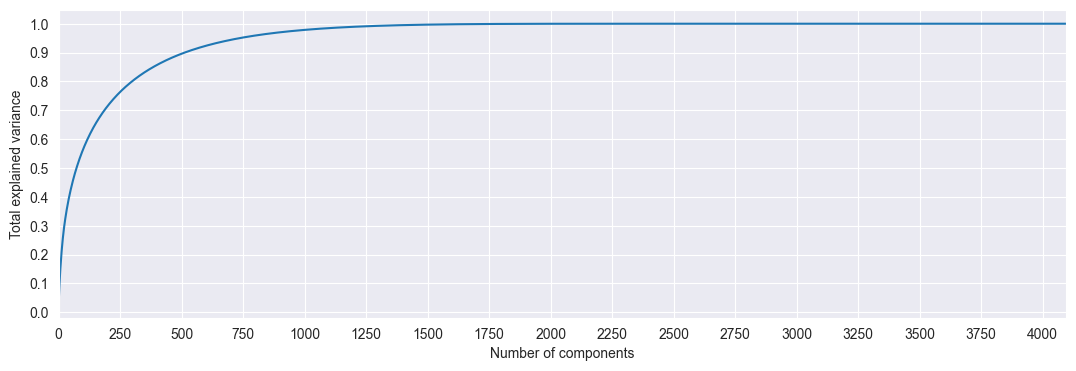

In [46]:
plt.figure(figsize=(13, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 64 * 64)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 64 * 64, 250))
plt.show();

Можно заметить, что из 4096 пикселей:
    1. 1500 пикселей наиболее информативны и описывают около 100% дисперсии.
    2. 500 пикселей описывают около 90% дисперсии.
    3. 270 пикселей описываются около 80% дисперсии.

Это означает, что датасет можно уменьшить минимум в 2.7 раза, при этом не сильно ухудшив результат задачи кластеризации.

#### Собственная реализация K-means

In [47]:
import numpy.typing as npt
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.estimator_checks import check_estimator


class SimpleKMeans(BaseEstimator, ClusterMixin):

    def __init__(self, n_clusters=8, tol=0.001, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def get_labels(self, X: npt.NDArray) -> npt.NDArray:
        dists = np.linalg.norm(
            X[..., None] - self.cluster_centers_.T, axis=1
        )
        labels = np.argmin(dists, axis=1)
        return labels

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        return self.get_labels(X)

    def fit(self, X: npt.ArrayLike, y=None) -> "SimpleKMeans":
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        X = check_array(X)

        self.n_features_in_ = X.shape[1]

        self.cluster_centers_ = X[self.random_state_.choice(len(X), size=self.n_clusters, replace=False), :]

        max_center_shift = np.inf
        while max_center_shift > self.tol:
            self.labels_ = self.get_labels(X)

            new_centers = np.empty((self.n_clusters, self.n_features_in_))
            for label in np.unique(self.labels_):
                new_centers[label] = np.mean(X[self.labels_ == label], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))

            self.cluster_centers_ = new_centers

        return self


Необходимо проверить собственную реализацию алгоритма KMeans на совместимость с sklearn:

In [48]:
check_estimator(SimpleKMeans())

#### Обучение

In [49]:
X_reduced_arr = []
for components in [1500, 500, 270]:
    pca = PCA(n_components=components)
    X_reduced_arr.append(pca.fit_transform(X))

In [52]:
import pathlib
import itertools
import time
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score

RESULTS_PATH = pathlib.Path("results_task5.csv")


def train_and_store(estimator, param_grid=None):
    param_grid = param_grid if param_grid is not None else {}
    param_combs = [
        dict(params) for params in
        itertools.product(
            *([(name, v) for v in vs] for (name, vs) in param_grid.items())
        )
    ]

    results = []
    for X in X_reduced_arr:
        best_ars = None

        for params in param_combs:
            cloned_estimator = clone(estimator).set_params(**params)

            start_t = time.perf_counter()
            pred = cloned_estimator.fit_predict(X)
            fit_predict_time_s = (time.perf_counter() - start_t)

            ari = adjusted_rand_score(y, pred)
            if best_ars is None or ari > best_ars[0]:
                best_ars = ari, fit_predict_time_s, params

        print(
            f"Count of components: {X.shape[1]}:",
            f"Best params: {best_ars[2]}",
            f"Adjusted round score: {best_ars[0]}",
            f"Time: {best_ars[1]}",
            "",
            sep="\n",
        )

        results.append(
            {
                "Clusterer": estimator.__class__.__name__,
                "Input dimension": X.shape[1],
                "fit_predict time, s": best_ars[1],
                "Adjusted round score": best_ars[0],
            }
        )

    pd.DataFrame(results).to_csv(RESULTS_PATH, mode="a", header=not RESULTS_PATH.exists())

In [53]:
%%time

train_and_store(SimpleKMeans(n_clusters=10, random_state=0))

Count of components: 1500:
Best params: {}
Adjusted round score: 0.09273170796698753
Time: 134.9234507000001

Count of components: 500:
Best params: {}
Adjusted round score: 0.10087149105760612
Time: 43.14067149999937

Count of components: 270:
Best params: {}
Adjusted round score: 0.09301069061267644
Time: 21.922773000000234

CPU times: total: 3min 19s
Wall time: 3min 19s


In [54]:
%%time
from sklearn.cluster import KMeans

train_and_store(
    KMeans(n_clusters=10, n_init="auto", random_state=0),
    param_grid={
        "algorithm": ["lloyd", "elkan"],
    },
)

Count of components: 1500:
Best params: {'algorithm': 'lloyd'}
Adjusted round score: 0.09857708277970499
Time: 2.116964500000904

Count of components: 500:
Best params: {'algorithm': 'lloyd'}
Adjusted round score: 0.08803192449206325
Time: 0.6372495999985404

Count of components: 270:
Best params: {'algorithm': 'lloyd'}
Adjusted round score: 0.07655835295921626
Time: 0.45145009999941976

CPU times: total: 57.2 s
Wall time: 5.64 s


In [55]:
%%time
from sklearn.cluster import DBSCAN

train_and_store(
    DBSCAN(n_jobs=-1),
    param_grid={
        "eps": [750],
        "min_samples": [20],
    }
)

Count of components: 1500:
Best params: {'eps': 750, 'min_samples': 20}
Adjusted round score: 0.03419453538635827
Time: 3.2431487000012567

Count of components: 500:
Best params: {'eps': 750, 'min_samples': 20}
Adjusted round score: 0.028977526837568008
Time: 1.3442274999997608

Count of components: 270:
Best params: {'eps': 750, 'min_samples': 20}
Adjusted round score: 0.015018826580331624
Time: 1.2290293999994901

CPU times: total: 57.7 s
Wall time: 5.83 s


#### Вывод

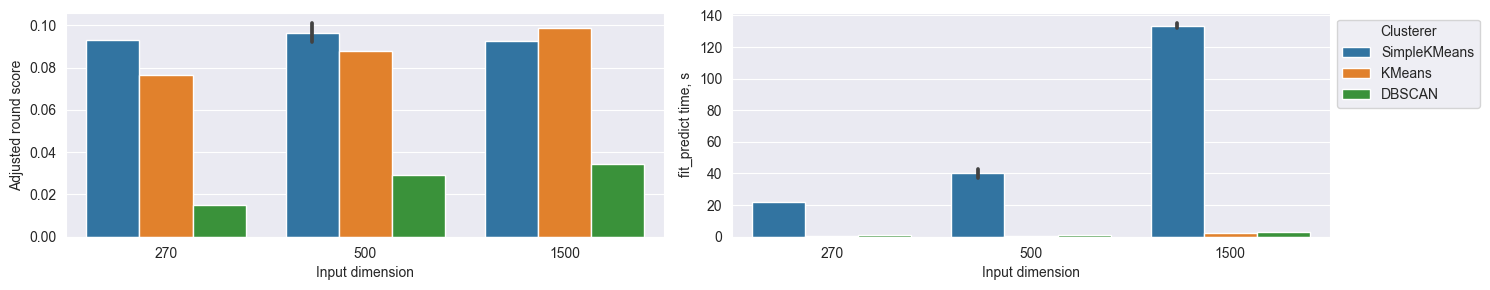

In [58]:
import seaborn as sns

results = pd.read_csv(RESULTS_PATH)

fig, axs = plt.subplots(ncols=2, figsize=(15, 3))
for metric, ax in zip(["Adjusted round score", "fit_predict time, s"], axs.flatten()):
    sns.barplot(results, x="Input dimension", y=metric, hue="Clusterer", ax=ax)
    if metric == "fit_predict time, s":
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()

fig.tight_layout()